In [ ]:
import pandas as pd
import re
import chardet
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import calendar

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
file_path = '/content/corpus.csv'

df = pd.read_csv(file_path, encoding='latin1', engine='python', on_bad_lines='skip')


In [ ]:
import pandas as pd
from urllib.parse import urlparse

# Define a function to extract the news channel name
def extract_channel_name(url):
    try:
        # Parse the URL
        parsed_url = urlparse(url)
        # Extract the domain name
        domain = parsed_url.netloc
        # Handle cases with subdomains
        if domain.startswith('www.'):
            domain = domain[4:]
        # Extract the base domain name which usually is the news channel name
        domain_parts = domain.split('.')
        # If there is a subdomain like 'money.cnn', take the second last part
        if len(domain_parts) > 2:
            # Adjust the index if 'co' is part of the domain e.g., 'co.uk'
            if domain_parts[-2] == 'co':
                channel_name = domain_parts[-3]
            else:
                channel_name = domain_parts[-2]
        else:
            channel_name = domain_parts[0]
        return channel_name
    except Exception as e:
        print(f"Error parsing url {url}: {e}")
        return None

# Apply the function to the 'url' column of the dataframe
df['channel_name'] = df['url'].apply(extract_channel_name)




In [ ]:
# Display the first few rows to verify
print(df[['url', 'channel_name']].head(200))


                                                   url   channel_name
0    http://economictimes.indiatimes.com/news/polit...     indiatimes
1    http://indianexpress.com/article/opinion/colum...  indianexpress
2            http://indianexpress.com/astrotype/daily/  indianexpress
3    http://money.cnn.com/2014/01/16/investing/stoc...            cnn
4    http://indianexpress.com/article/india/india-o...  indianexpress
..                                                 ...            ...
195  http://nypost.com/2014/01/14/fine-dining-sitte...         nypost
196          http://money.cnn.com/news/economy/europe/            cnn
197  http://nypost.com/2014/01/15/some-super-bowl-s...         nypost
198  http://money.cnn.com/2014/01/16/technology/app...            cnn
199  http://economictimes.indiatimes.com/news/econo...     indiatimes

[200 rows x 2 columns]


In [ ]:
df['last_crawl_date'] = pd.to_datetime(df['last_crawl_date'])

df['year'] = df['last_crawl_date'].dt.year
df['month'] = df['last_crawl_date'].dt.month
df['day'] = df['last_crawl_date'].dt.day
# and so on for other components


# Drop 'Unnamed: 0' and 'url' columns from the DataFrame
df = df.drop(['Unnamed: 0','last_crawl_date','url'], axis=1)

In [ ]:
# Function to convert month number to month name safely
def get_month_name(month_num):
    try:
        # Ensure the month number is an integer and within the range 1-12
        month_num = int(month_num)
        if 1 <= month_num <= 12:
            return calendar.month_name[month_num]
        else:
            return None  # Return None or an appropriate placeholder for invalid data
    except ValueError:
        # Handle the case where the month number is not an integer
        return None

# Map the month numbers to month names using the above function
df['month_name'] = df['month'].apply(get_month_name)

# Display the DataFrame to verify the changes
df.head()




,body,title,channel_name,year,month,day,month_name
0,NEW DELHI: The Aam Aadmi Party's (AAP's) stanc...,GR Gopinath slams AAP's stand on FDI in retail...,indiatimes,2014,1,16,January
1,Japans ties with India do not target any coun...,Politics is now | The Indian Express,indianexpress,2014,1,16,January
2,SAGITTARIUS NOV 23-DEC 22. Its almost time to...,Daily | Astrotype | The Indian Express,indianexpress,2014,1,16,January
3,Bad corporate news sends stocks lower. Bad new...,Bad corporate news sends stocks lower - Jan. 1...,cnn,2014,1,16,January
4,Related. 2008 Batla House encounter convict Sh...,Batla House encounter: HC denies bail to convi...,indianexpress,2014,1,16,January


In [ ]:
# Given list of channel names
channel_list = ['india', 'times', 'indian', 'express', 'cnn', 'ny', 'post', 'India', 'Times', 'Economic', 'Times', 'New', 'York', 'Post', 'Indian', 'Express', ' CNN']

# List of month names and their abbreviations
months_and_abbreviations = [
    'January', 'Jan',
    'February', 'Feb',
    'March', 'Mar',
    'April', 'Apr',
    'May',  # May does not have an abbreviation
    'June', 'Jun',
    'July', 'Jul',
    'August', 'Aug',
    'September', 'Sep',
    'October', 'Oct',
    'November', 'Nov',
    'December', 'Dec'
]

# Extend the original list with the months and their abbreviations
channel_list.extend(months_and_abbreviations)

# Print the updated list
print(channel_list)


['india', 'times', 'indian', 'express', 'cnn', 'ny', 'post', 'India', 'Times', 'Economic', 'Times', 'New', 'York', 'Post', 'Indian', 'Express', ' CNN', 'January', 'Jan', 'February', 'Feb', 'March', 'Mar', 'April', 'Apr', 'May', 'June', 'Jun', 'July', 'Jul', 'August', 'Aug', 'September', 'Sep', 'October', 'Oct', 'November', 'Nov', 'December', 'Dec']


In [ ]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Add 'channel_list' as a parameter to the function
def clean_and_combine_text(title, body, month, day, month_name, channel_name, channel_list):
    # Define patterns to remove: month names (with optional period), days, channel names, and any four-digit numbers (likely years)
    patterns_to_remove = [
        r'\b{}\b\.?'.format(re.escape(str(month))),  # Match month with optional period
        r'\b{}\b'.format(re.escape(str(day))),
        r'\b{}\b'.format(re.escape(month_name)),  # No need to escape this as we expect it to be a word
        r'\b{}\b'.format(re.escape(channel_name)),
        r'\b\d{4}\b',  # To remove a four-digit number, likely the year
        r'\b\d+\b',  # To remove all numbers (they might be strings)
        r'\b[a-zA-Z]\b'  # To remove single alphabet characters
    ]

    # Clean the title using the patterns defined above
    for pattern in patterns_to_remove:
        title = re.sub(pattern, '', title, flags=re.IGNORECASE)

    # Special handling for periods after month abbreviations
    title = re.sub(r'\b{}\.'.format(month_name), '', title, flags=re.IGNORECASE)

    # Remove extra spaces and potential trailing periods
    title_clean = re.sub(r" +", ' ', title.strip('. '))

    # Further clean the title text (preserve case)
    text = re.sub(r'[^\w\s]', '', title_clean)

    # Tokenize text
    tokens = word_tokenize(text)

    # Create a combined set of stopwords and channel list items (all in lowercase)
    combined_removals = set(stopword.lower() for stopword in stopwords.words('english')) \
                    .union(set(channel.lower() for channel in channel_list))

    # Remove both stopwords and tokens from the combined_removals
    tokens = [word for word in tokens if word.lower() not in combined_removals]


    # Lemmatize tokens (considering case-sensitivity)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Rejoin tokens into a string without converting to lower case
    cleaned_text = ' '.join(tokens)

    return cleaned_text

# When calling the function, make sure to pass the channel_list as well
df['cleaned_title'] = df.apply(lambda x: clean_and_combine_text(
    x['title'],
    x['body'],
    x['month'],
    x['day'],
    x['month_name'],
    x['channel_name'],
    channel_list),  # Pass the channel_list here
    axis=1
)


In [ ]:
df.drop(columns=['title', 'month'], inplace=True)


In [ ]:
# Get a list of all column names except 'channel_name'
columns_except_channel = [col for col in df.columns if col != 'channel_name']

# Add 'channel_name' to the end of the list
new_column_order = columns_except_channel + ['channel_name']

# Reindex the DataFrame with the new column order
df = df[new_column_order]

# Now 'channel_name' should be the last column
df.head(10)





,body,year,day,month_name,cleaned_title,channel_name
0,NEW DELHI: The Aam Aadmi Party's (AAP's) stanc...,2014,16,January,GR Gopinath slam AAP stand FDI retail,indiatimes
1,Japans ties with India do not target any coun...,2014,16,January,Politics,indianexpress
2,SAGITTARIUS NOV 23-DEC 22. Its almost time to...,2014,16,January,Daily Astrotype,indianexpress
3,Bad corporate news sends stocks lower. Bad new...,2014,16,January,Bad corporate news sends stock lower,cnn
4,Related. 2008 Batla House encounter convict Sh...,2014,16,January,Batla House encounter HC denies bail convict S...,indianexpress
5,Related. A three-judge bench headed by Justice...,2014,16,January,Supreme Court reserve order scrapping coal blo...,indianexpress
6,Lew: Debt ceiling crunch to come sooner than t...,2014,16,January,Lew Debt ceiling crunch come sooner thought,cnn
7,Because apparently Americans don't have easy e...,2014,16,January,Hershey make chocolate printer,cnn
8,Time Warner to sell HQ for $1.3 billion. Time ...,2014,16,January,Time Warner sell HQ billion,cnn
9,5 things we want for Windows 9. Windows 8 is c...,2014,16,January,thing want Windows,cnn


In [ ]:
import re
import pandas as pd

def remove_dates_times_and_sources(text):
    # Regular expression for full and abbreviated month names followed by day numbers
    text = re.sub(
        r'\b(?:Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)\s+\d{1,2}',
        '', text, flags=re.IGNORECASE)

    # Regular expression for times in 'HHMM AM' or 'HHMM PM' format
    text = re.sub(
        r'\b\d{1,4}\s?(?:AM|PM)\b',
        '', text, flags=re.IGNORECASE)

    # Regular expression for specific source names like "CNNMoney"
    text = re.sub(
        r'CNNMoney',
        '', text, flags=re.IGNORECASE)

    # Regular expression for years followed by times and timezones like "2010 943 ET"
    # Now also considering variable spaces between the year and 'ET' or 'PST'
    text = re.sub(
        r'\b\d{4}\s*\d{0,4}\s*(?:AM|PM|ET|PST)\b',
        '', text, flags=re.IGNORECASE)

    # Remove extra spaces left after the removal of words and patterns
    text = re.sub(r'\s{2,}', ' ', text)  # Replace two or more spaces with one space

    # Trim spaces at the start and end of the text
    text = text.strip()

    return text

# Apply the function to clean the 'body' column
df['body'] = df['body'].apply(remove_dates_times_and_sources)



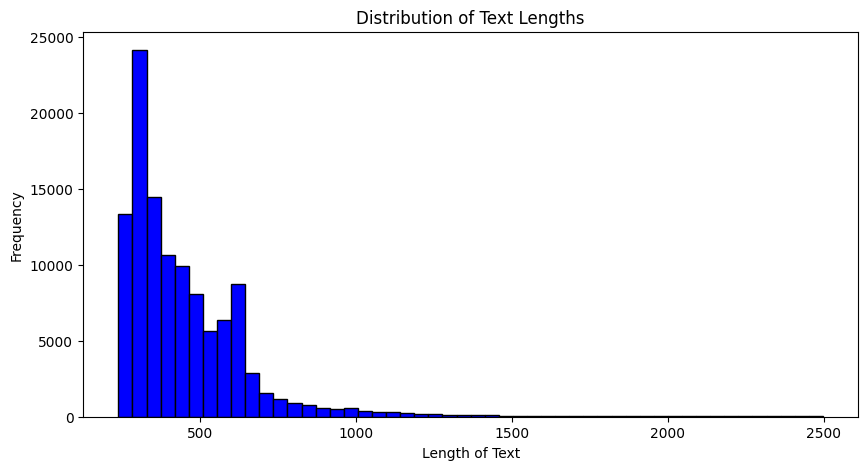

In [ ]:
import matplotlib.pyplot as plt
# Calculate the length of texts
df['text_length'] = df['body'].dropna().apply(lambda x: len(x.split()))

# Plot the distribution of text lengths
plt.figure(figsize=(10,5))
plt.hist(df['text_length'], bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.show()


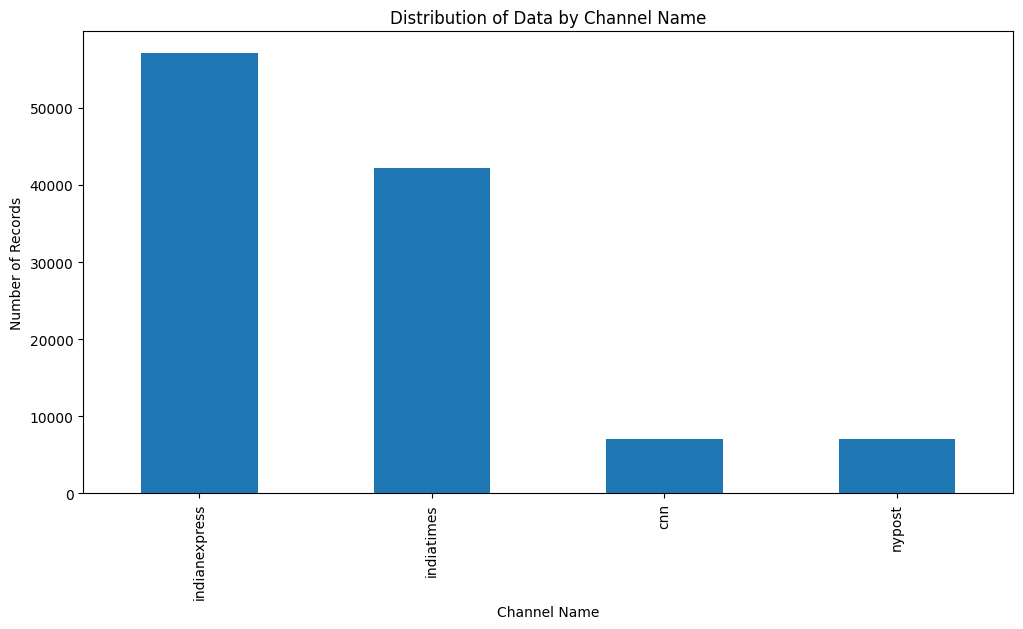

In [ ]:
import matplotlib.pyplot as plt

# Calculate the distribution of channel names
channel_distribution = df['channel_name'].value_counts()

# Plot the distribution
plt.figure(figsize=(12, 6))
channel_distribution.plot(kind='bar')
plt.title('Distribution of Data by Channel Name')
plt.xlabel('Channel Name')
plt.ylabel('Number of Records')
plt.xticks(rotation=90)  # Rotate the x labels to show them more clearly
plt.show()


In [ ]:
# Calculate the number of rows per channel
rows_per_channel = 8000 // 4

# Create an empty DataFrame to hold the reduced data
reduced_df = pd.DataFrame()

# Group by 'channel_name' and sample rows from each group
for name, group in df.groupby('channel_name'):
    reduced_df = pd.concat([reduced_df, group.sample(n=rows_per_channel, random_state=1)])

# Reset the index of the reduced DataFrame
reduced_df = reduced_df.reset_index(drop=True)

# Verify the operation
print(reduced_df['channel_name'].value_counts())


cnn              2000
indianexpress    2000
indiatimes       2000
nypost           2000
Name: channel_name, dtype: int64


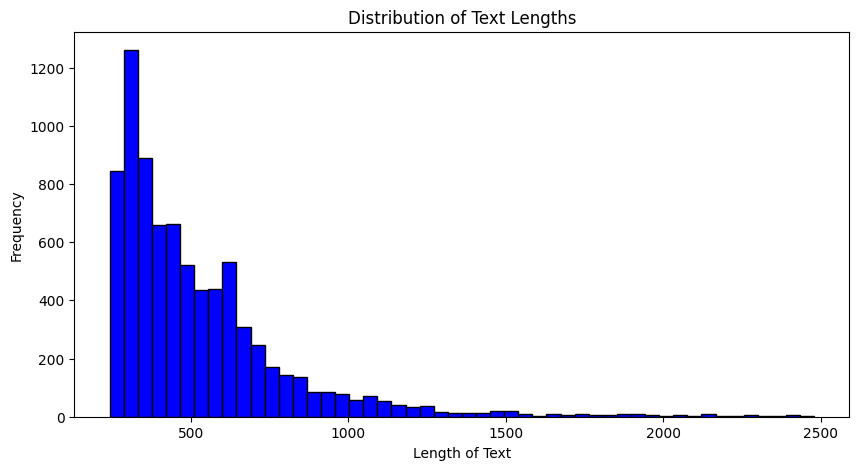

In [ ]:
import matplotlib.pyplot as plt
# Calculate the length of texts
reduced_df['text_length'] = reduced_df['body'].dropna().apply(lambda x: len(x.split()))

# Plot the distribution of text lengths
plt.figure(figsize=(10,5))
plt.hist(reduced_df['text_length'], bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# Save the DataFrame to a CSV file
reduced_df.to_csv('reduced_data.csv', index=False)

# Use the Colab file manager to download the file to your local system
from google.colab import files
files.download('reduced_data.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df.head(50)

In [ ]:
# Installation (if needed)
!pip install transformers datasets

# Import necessary libraries
from transformers import AutoModelForTokenClassification, AutoTokenizer
from transformers import pipeline




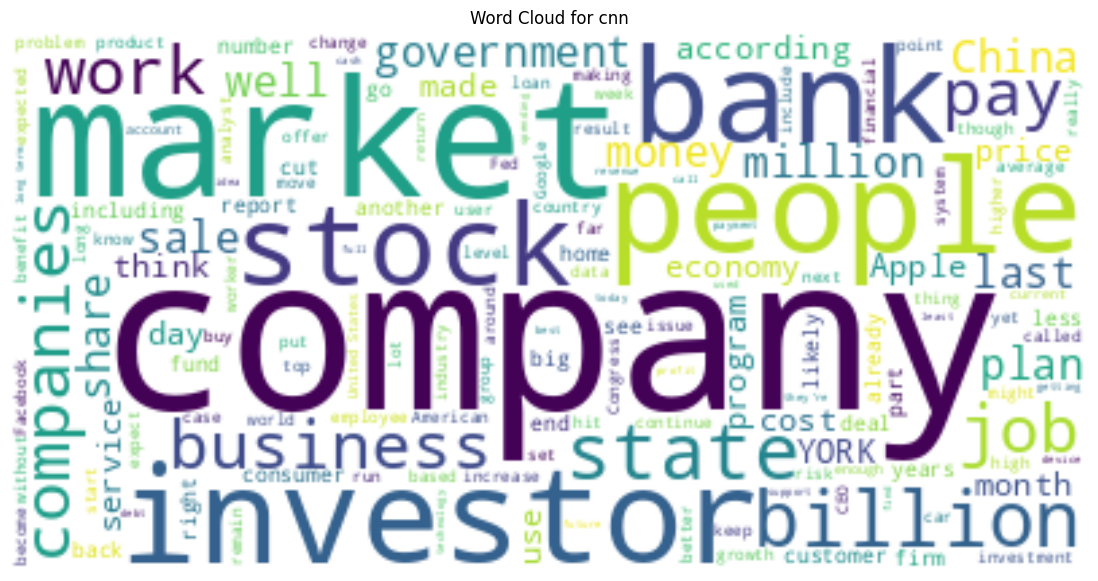

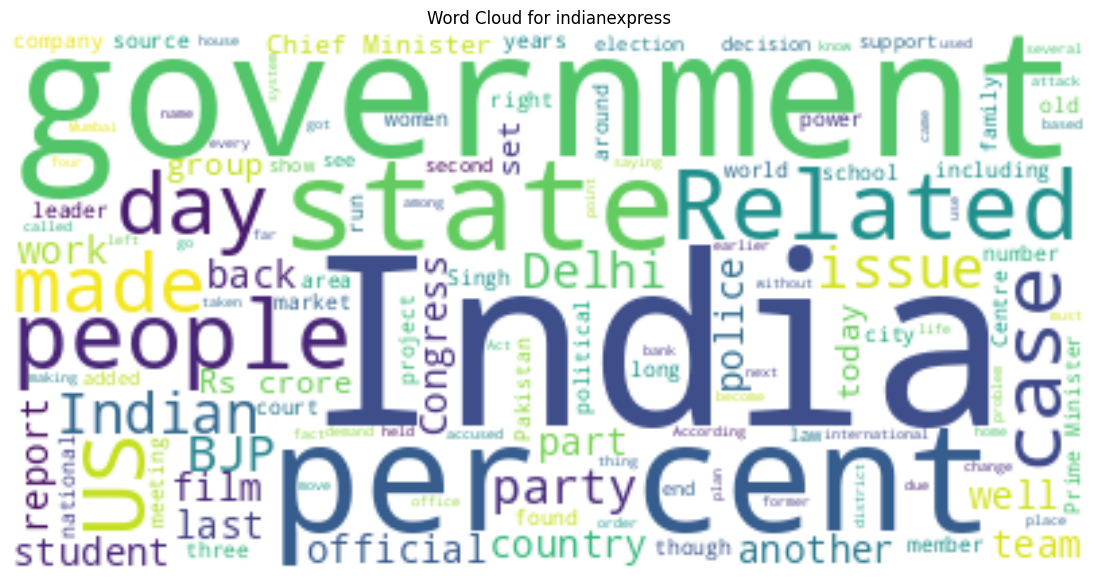

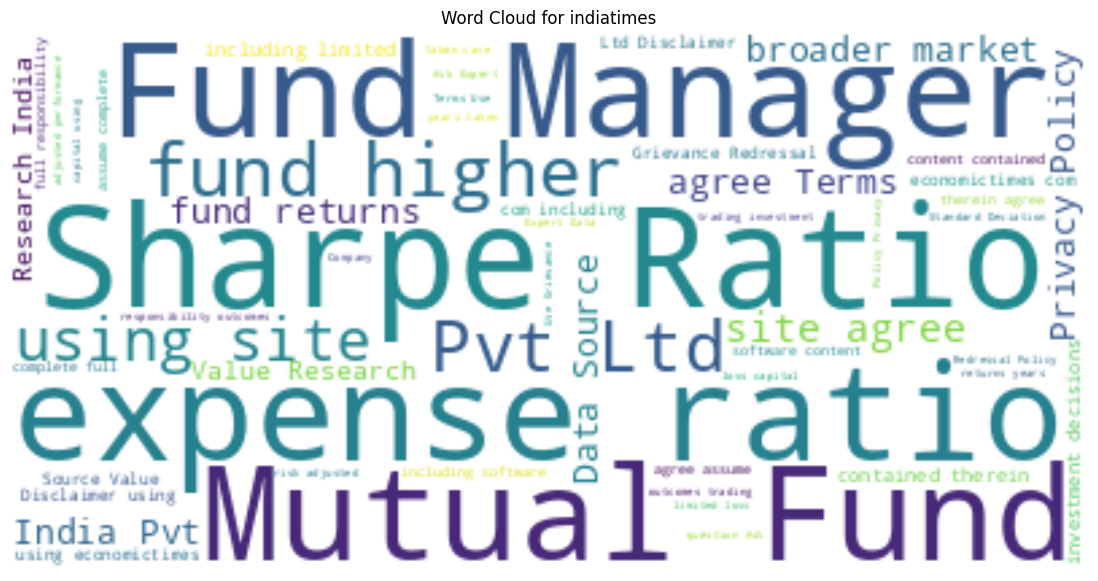

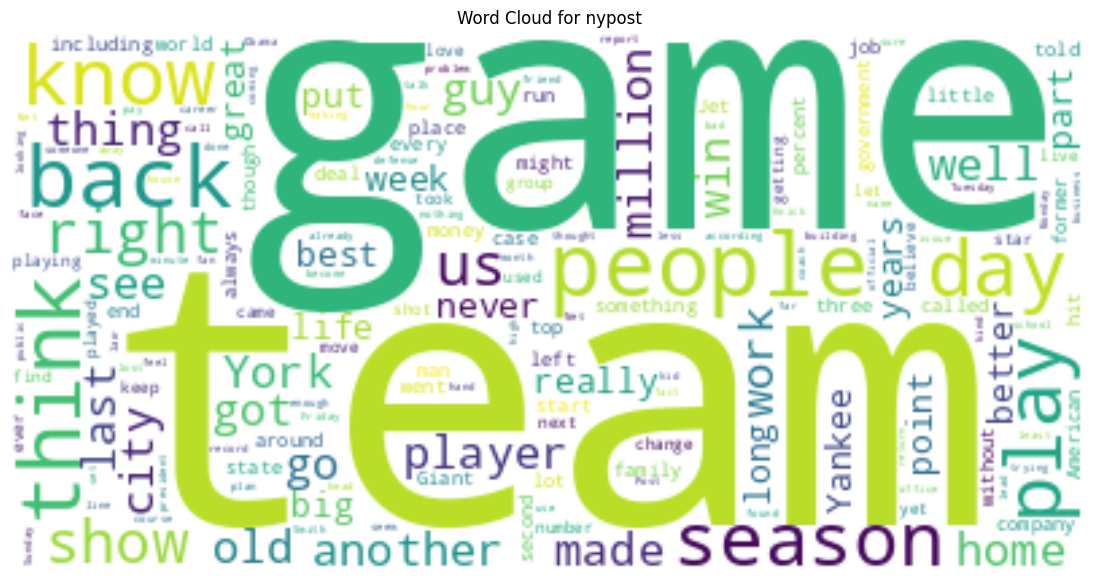

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

# Load standard stop words and add custom stop words
standard_stop_words = set(stopwords.words('english'))
custom_stop_words = {'said', 'like', 'also', 'one', 'two', 'would', 'could', 'may', 'etc', 'many', 'still', 'get', 'year', 'say', 'NEW' 'YORK', 'look', 'good', 'going', 'get', 'even', 'help', 'given', 'give', 'time', 'much', 'asked', 'want', 'first', 'However', 'come', 'means', 'way', 'want', 'says', 'need', 'U', 'new', 'make', 'take', 'since', }
# Combine standard stop words with custom stop words
stop_words = standard_stop_words.union(custom_stop_words)

# Assuming reduced_df is your DataFrame with the channel_name column
# Group the text in the 'body' column by 'channel_name'
grouped_text = reduced_df.groupby('channel_name')['body'].apply(lambda texts: " ".join(texts.dropna()))

# Create a word cloud for each unique class in 'channel_name'
for channel, text in grouped_text.items():
    # Remove stop words
    text = " ".join([word for word in text.split() if word.lower() not in stop_words])

    # Generate the word cloud considering the extended stop words
    wordcloud = WordCloud(background_color="white", stopwords=stop_words).generate(text)

    # Display the generated image:
    plt.figure(figsize=(16,7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {channel}')
    plt.axis("off")
    plt.show()


In [ ]:
reduced_df.shape

(8000, 7)